## Import dependencies all you need

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import csv
import nest_asyncio
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, GRU, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from  sklearn.metrics import confusion_matrix, accuracy_score
import emoji
import string
from keras.utils import to_categorical
from ast import literal_eval
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
nltk.download('stopwords')
nltk.download('punkt')
seed = 10
np.random.seed(seed)
nest_asyncio.apply()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read csv
ps: i use (;) to separate each column. The reason is to eliminate redundant punctuation at tex_id column which is original tweet.

In [2]:
df = pd.read_csv('manual_data_clean_polarity.csv', delimiter=';')

In [3]:
df.head()

,tweet,manual_label,tweet_cleaned_id,tweet_preprocessed,polarity_score,polarity
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",2,kembangkan etle polda dapat penghargaan di ra...,"['kembang', 'etle', 'polda', 'dapat', 'harga',...",6,positif
1,Sosialisasi etle dan app smart city\n\n#polsek...,1,sosialisasi etle dan app smart city,"['sosialisasi', 'etle', 'dan', 'app', 'smart',...",0,netral
2,"Berita populer kumparanOTO, Selasa (13/12) det...",1,berita populer kumparanoto selasa detail vesp...,"['berita', 'populer', 'kumparanoto', 'selasa',...",10,positif
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",1,mimin kasih info ya gaes kita mau uji coba etl...,"['mimin', 'kasih', 'informasi', 'iya', 'teman'...",3,positif
4,personil lalu lintas polres badung melaksanaka...,2,personil lalu lintas polres badung melaksanaka...,"['personil', 'lalu', 'lintas', 'polres', 'badu...",-11,negatif


## Convert string of list type to actual list
at tweet_preprocessed, list type column casted to string type so we must convert 'em again to list form. Then we turn list type into sentence.

In [4]:
# change string of list to list
def string_to_list(value):
    return literal_eval(value)

def sentence_make(tokenized):
  return ' '.join(word for word in tokenized)

In [5]:
df['tweet_preprocessed'] = df['tweet_preprocessed'].apply(string_to_list)

In [6]:
# df['tweet_preprocessed'] = df['text_id']
df['tweet_preprocessed'][0]

['kembang',
 'etle',
 'polda',
 'dapat',
 'harga',
 'di',
 'rakernis',
 'fungsi',
 'gakkum']

## Tokenize text based on dataset (text corpus)
Machine can not understand string based input especially human natural language. We should turn our string input especially each word into registered integer. We did preprocessing to minimize same meaning of word but different integer.
After tokenizing word, we set padding to uniform each input row. In this case, we don't set pad value so the pad_sequence refer to max len of column.

In [7]:
X = df['tweet_preprocessed'].apply(sentence_make)
max_feature = 5000

tokenizer = Tokenizer(num_words=max_feature+1, split = ' ', oov_token='unk')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=57)

In [8]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  328,    2,   19,   65,  589,    4, 2411,
        590,  571])

In [9]:
import pickle
with open('./model/manual_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
X.shape

(6349, 57)

## Convert polarity to integer value
We map our polarity value to integer type & hot encode it into binary value. We hot encode it because we will use binary_crosentropy loss function. if you want to stick polarity_encode value, you can use sparse_binary_crossentrropy loss function.

In [25]:
# polarity_encode = {'negatif':0, 'netral':1, 'positif':2 }
# y = pd.get_dummies(df['manual_label']).values
# print(y)
y = df['manual_label']
print(y)

0       2
1       1
2       1
3       1
4       2
       ..
6344    1
6345    1
6346    1
6347    1
6348    0
Name: manual_label, Length: 6349, dtype: int64


## Create function for main program
To simplify our test case code, we define some function so our code look a bit clean.

In [19]:
def model_initiator(nn_type: str = "LSTM"):
    model = Sequential()
    model.add(Embedding(input_dim=max_feature+1, output_dim=64, input_length=X.shape[1]))
    model.add(Dropout(0.5))
    if nn_type == 'GRU':
        model.add(GRU(units=128, dropout=0.2, recurrent_dropout=0.2))
    else:
        model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(units=3, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    plot_model(model, to_file=f'{nn_type}_diagram.png', show_shapes=True, show_layer_names=True)
    return model
def conf_matrix(y_tests,y_preds):
    fig, ax = plt.subplots(figsize = (8,6))
    sns.heatmap(confusion_matrix(y_tests, y_preds), fmt='g', annot=True, cmap='Blues')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    ax.set_xlabel('Prediksi', fontsize=13)
    ax.set_xticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
    ax.set_ylabel('Aktual', fontsize=13)
    ax.set_yticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
    to_save_cf = f"{path_to_save}/CF.png"
    plt.savefig(fname=to_save_cf, format='png')
    plt.show()
    plt.close()
    return "confusion matrix saved"

def plot(model_history, param):
    if param.lower() == 'loss':
        plot_param = 'loss'
        plot_val = 'val_loss'
        dir_save = f"{path_to_save}/loss.png"
    else:
        plot_param = 'accuracy'
        plot_val = 'val_accuracy'
        dir_save = f"{path_to_save}/accuracy.png"
    plt.title(param)
    plt.plot(model_history.history[plot_param], label = 'train')
    plt.plot(model_history.history[plot_val], label = 'test')
    plt.legend()
    plt.savefig(fname=dir_save, format='png')
    plt.show()
    plt.close()
    return f"{plot_param}saved at {path_to_save}"


## Main Test Case
This section is our test case program. We are going to use different  train-test ratio, batch size, and epoch. Output of this test are Confusion Matrix heatmap, Loss graph, Accuracy graph, h5 model, classification report of each case, and report for whole case.

In [24]:
train_ratio = [0.2,0.3,0.4]
batch_list = [32,64,128]
epochs_list = [10,15]
result_bucket = []
model_type = "LSTM"
for tl in train_ratio[:1]:
    for el in epochs_list[:1]:
        for bl in batch_list[:1]:
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=tl, random_state = 0)
            models = model_initatiator(model_type)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 57, 128)           640000    
                                                                 
 dropout_6 (Dropout)         (None, 57, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 771,971
Trainable params: 771,971
Non-trainable params: 0
_________________________________________________________________


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 2)
print("y_train=",pd.Series(y_train).value_counts())
print("y_test=",pd.Series(y_test).value_counts())
under_sampling = RandomUnderSampler(random_state=0, replacement=True)
X_train, y_train = under_sampling.fit_resample(X_train, y_train)
print("balanced y_train=", pd.Series(y_train).value_counts())
print("balanced y_test=",pd.Series(y_test).value_counts())

y_train= 1    3881
0     764
2     434
Name: manual_label, dtype: int64
y_test= 1    1001
0     171
2      98
Name: manual_label, dtype: int64
balanced y_train= 0    434
1    434
2    434
Name: manual_label, dtype: int64
balanced y_test= 1    1001
0     171
2      98
Name: manual_label, dtype: int64


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 57, 64)            320064    
                                                                 
 dropout_10 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
41/41 [==============================

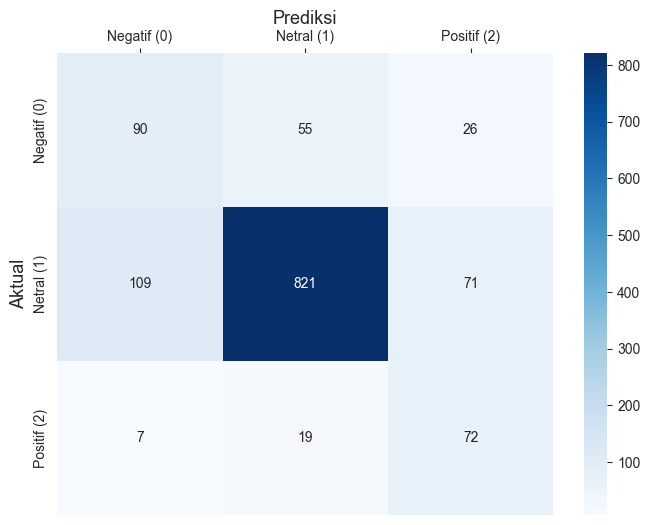

confusion matrix saved


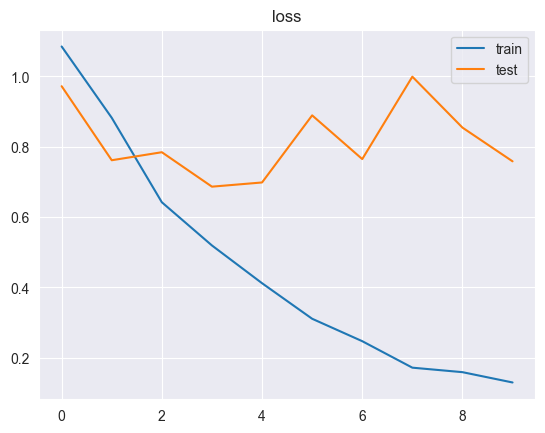

losssaved at manual_balanced_LSTM/0.2-10-32


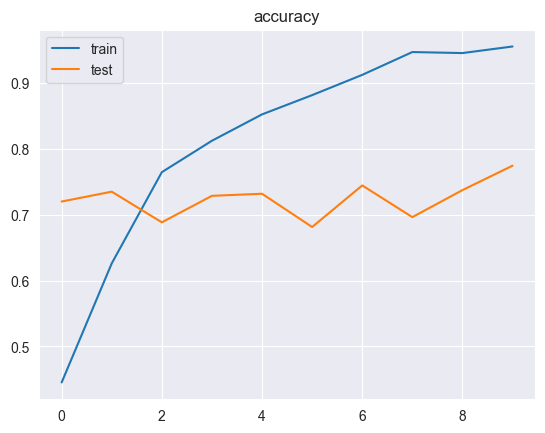

accuracysaved at manual_balanced_LSTM/0.2-10-32
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 57, 64)            320064    
                                                                 
 dropout_12 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________


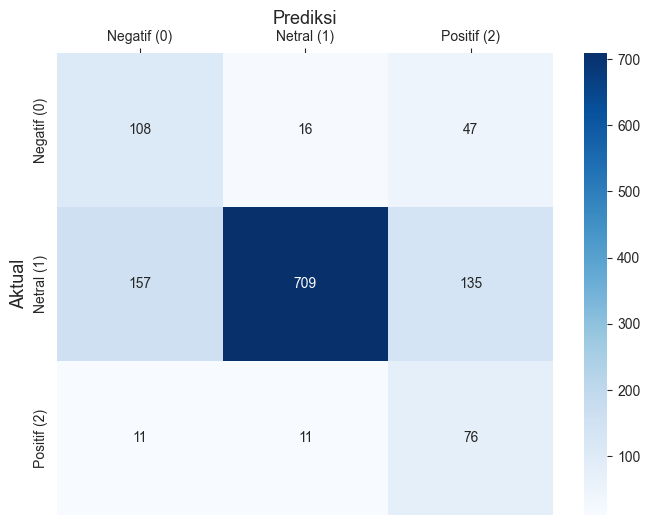

confusion matrix saved


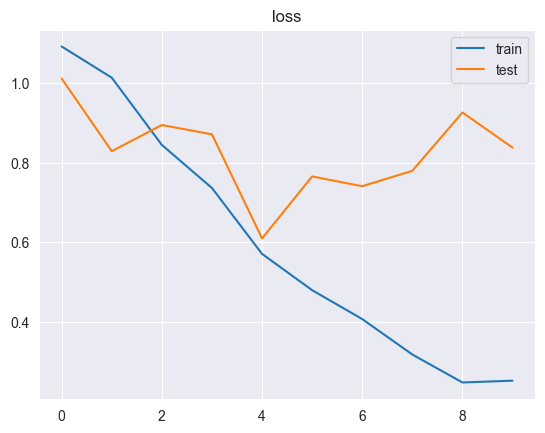

losssaved at manual_balanced_LSTM/0.2-10-64


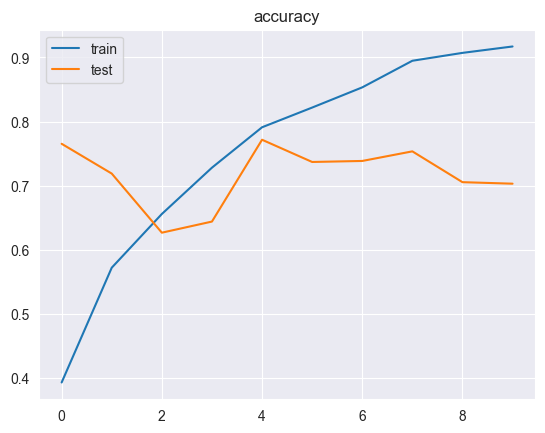

accuracysaved at manual_balanced_LSTM/0.2-10-64
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 57, 64)            320064    
                                                                 
 dropout_14 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________


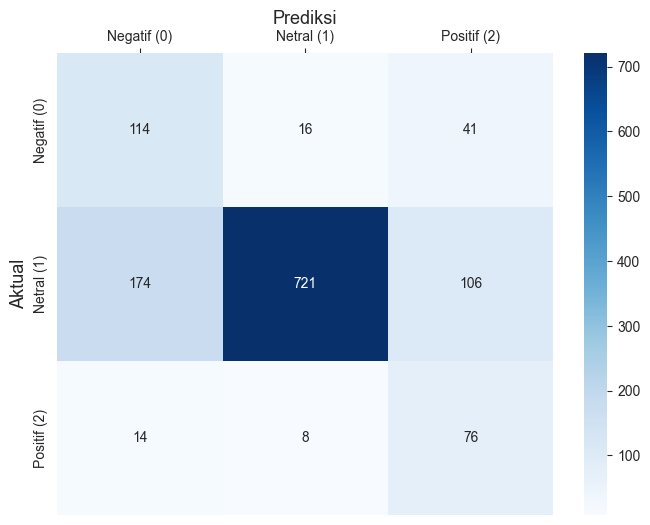

confusion matrix saved


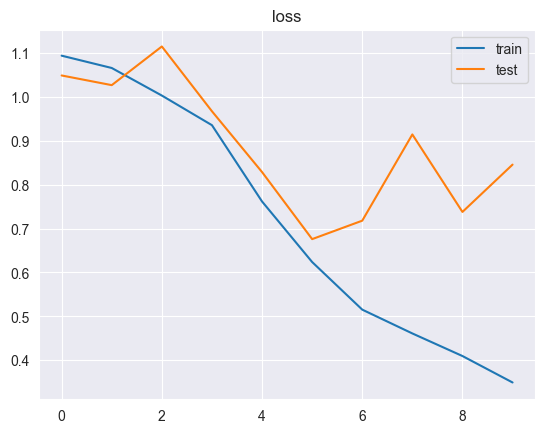

losssaved at manual_balanced_LSTM/0.2-10-128


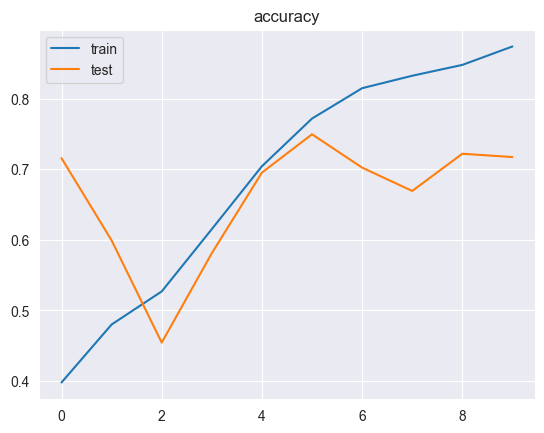

accuracysaved at manual_balanced_LSTM/0.2-10-128
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 57, 64)            320064    
                                                                 
 dropout_16 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

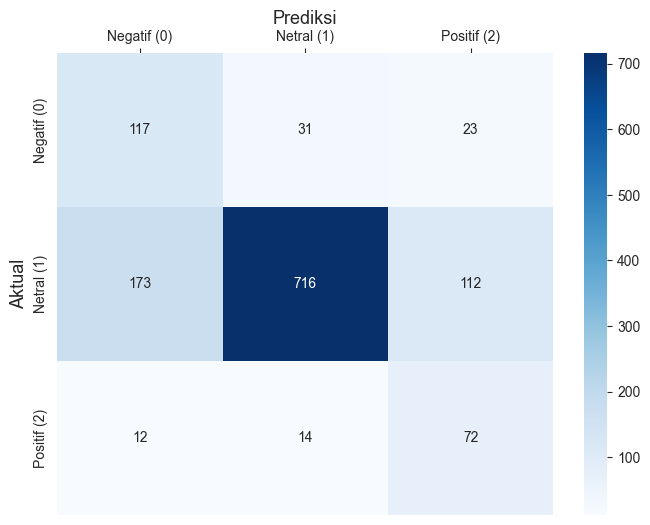

confusion matrix saved


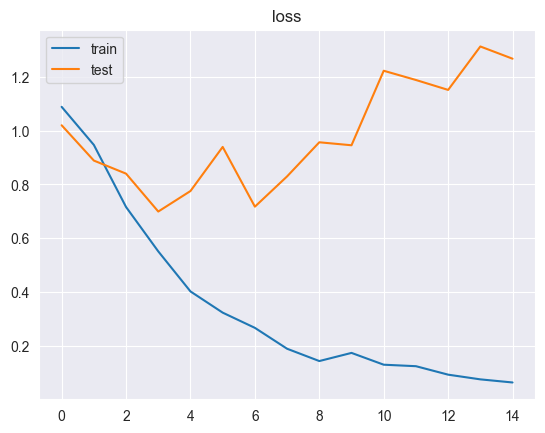

losssaved at manual_balanced_LSTM/0.2-15-32


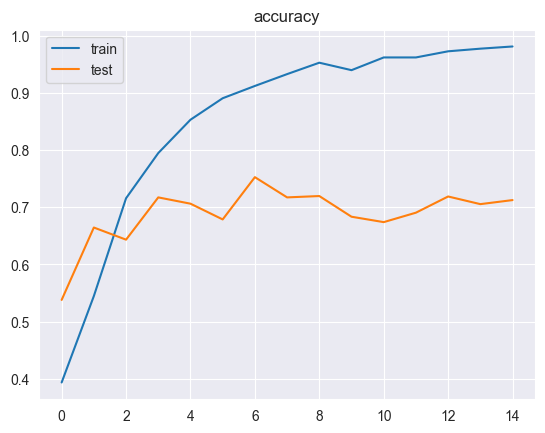

accuracysaved at manual_balanced_LSTM/0.2-15-32
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 57, 64)            320064    
                                                                 
 dropout_18 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________


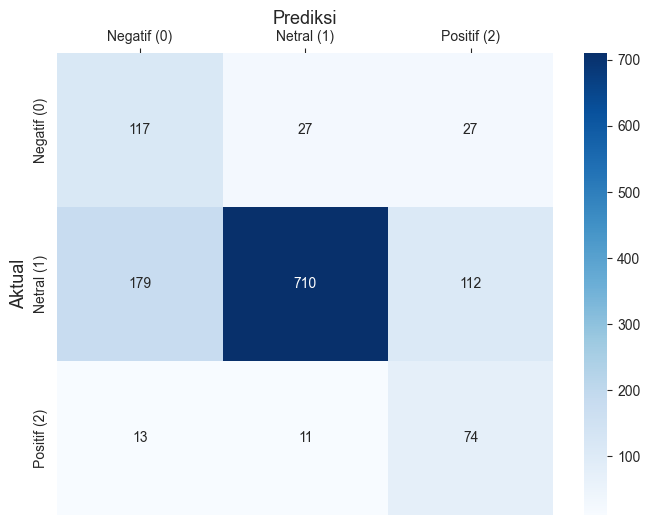

confusion matrix saved


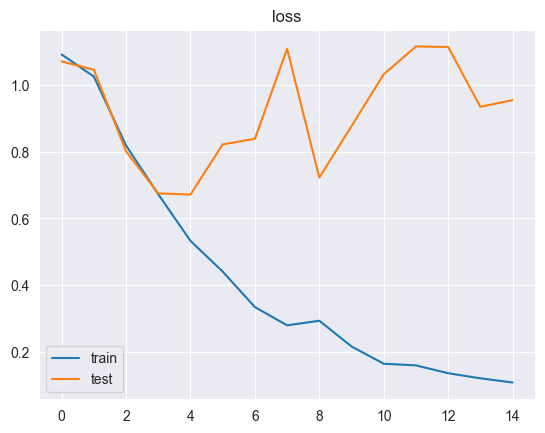

losssaved at manual_balanced_LSTM/0.2-15-64


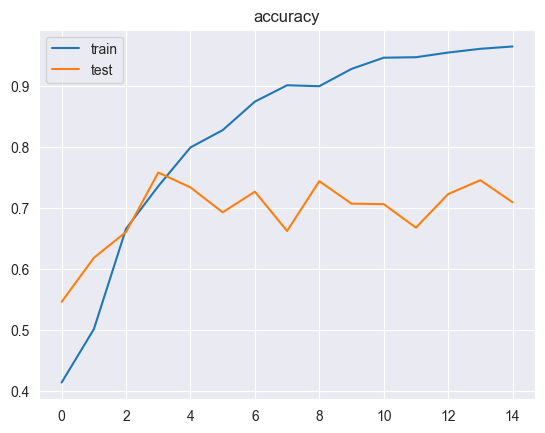

accuracysaved at manual_balanced_LSTM/0.2-15-64
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_20 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_10 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

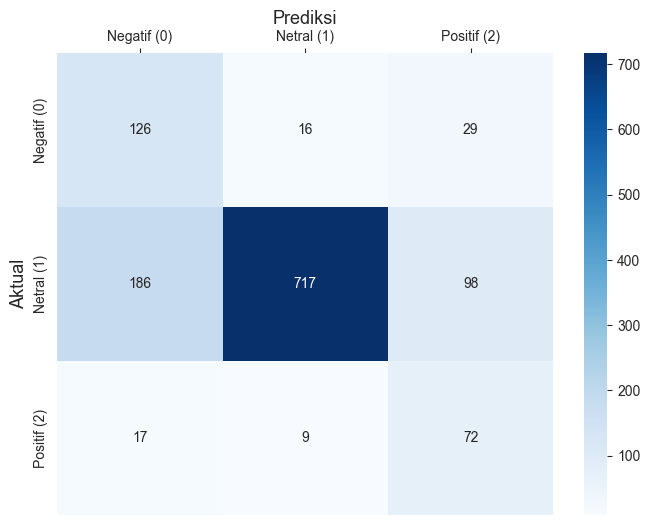

confusion matrix saved


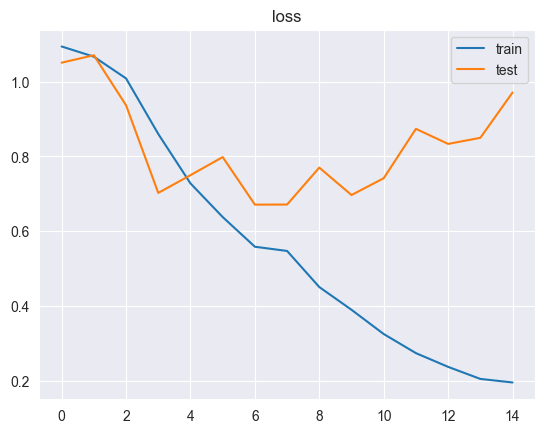

losssaved at manual_balanced_LSTM/0.2-15-128


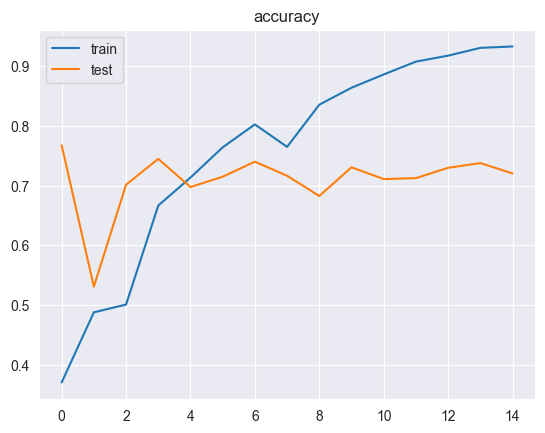

accuracysaved at manual_balanced_LSTM/0.2-15-128
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_22 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
________________________________________________________________

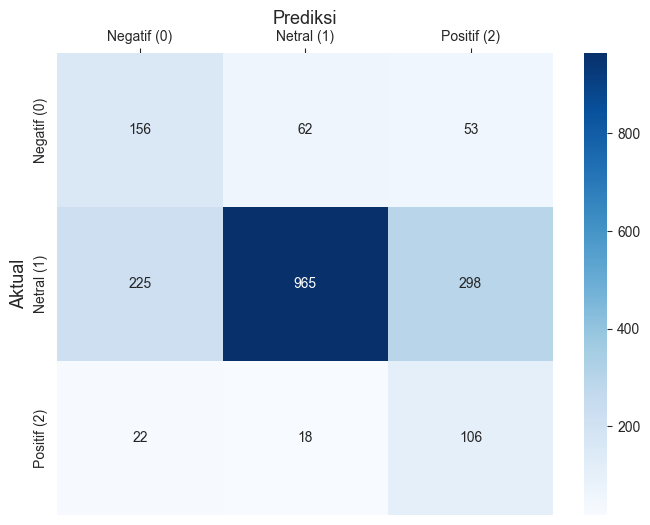

confusion matrix saved


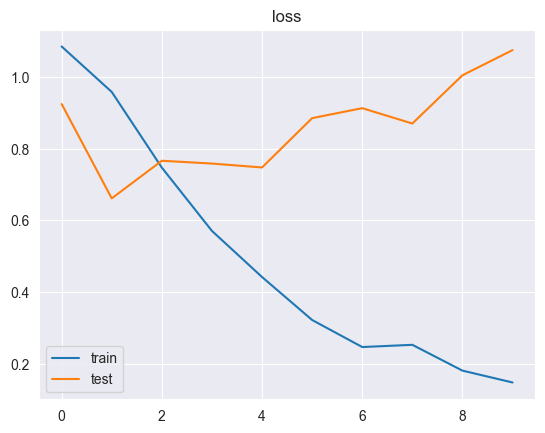

losssaved at manual_balanced_LSTM/0.3-10-32


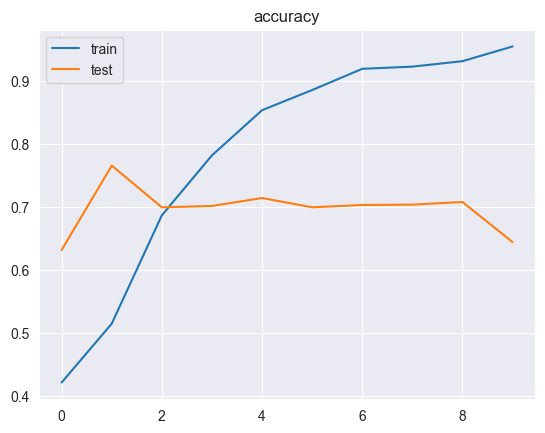

accuracysaved at manual_balanced_LSTM/0.3-10-32
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_24 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_12 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

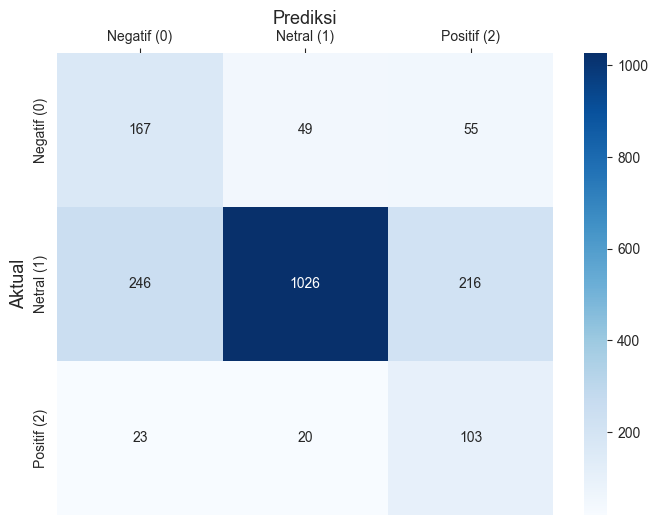

confusion matrix saved


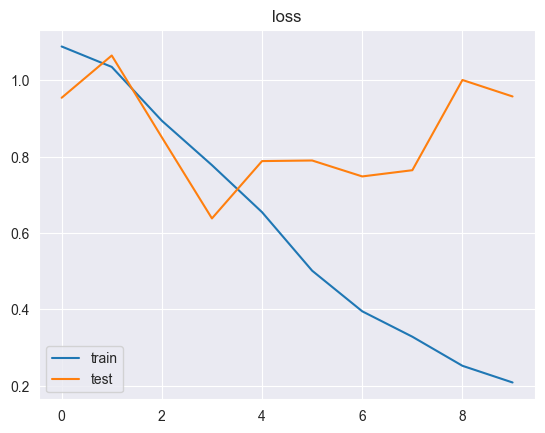

losssaved at manual_balanced_LSTM/0.3-10-64


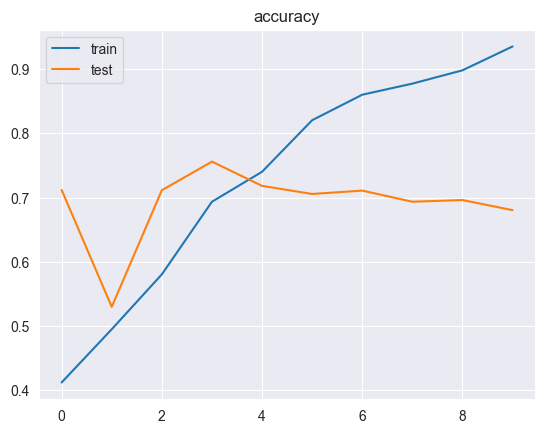

accuracysaved at manual_balanced_LSTM/0.3-10-64
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_26 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

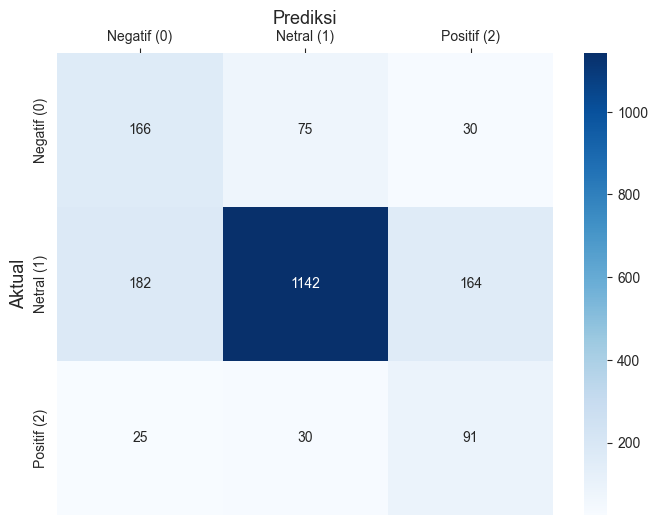

confusion matrix saved


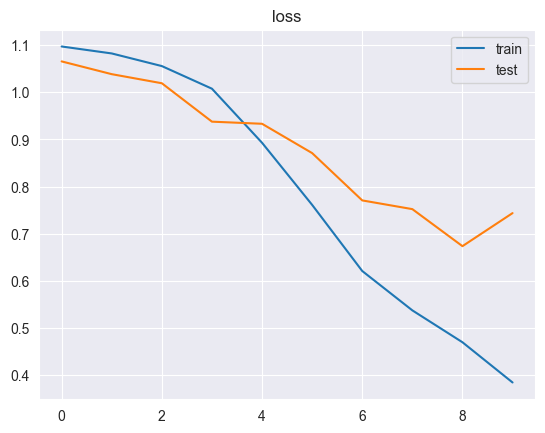

losssaved at manual_balanced_LSTM/0.3-10-128


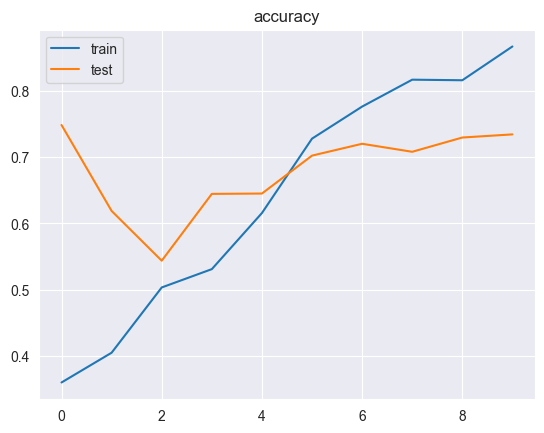

accuracysaved at manual_balanced_LSTM/0.3-10-128
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_28 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_14 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
________________________________________________________________

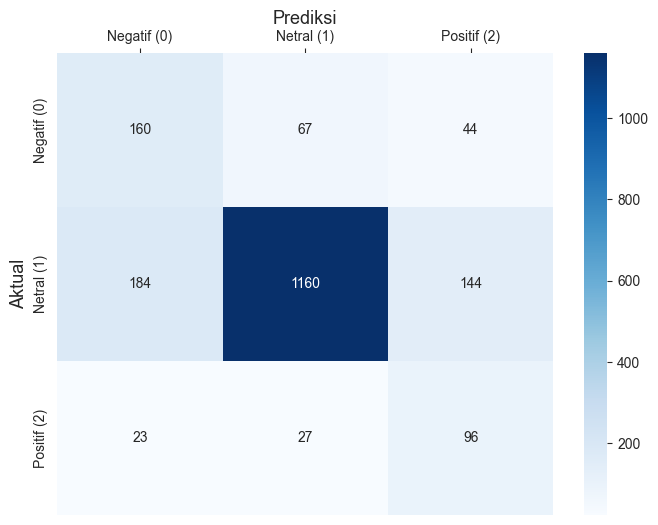

confusion matrix saved


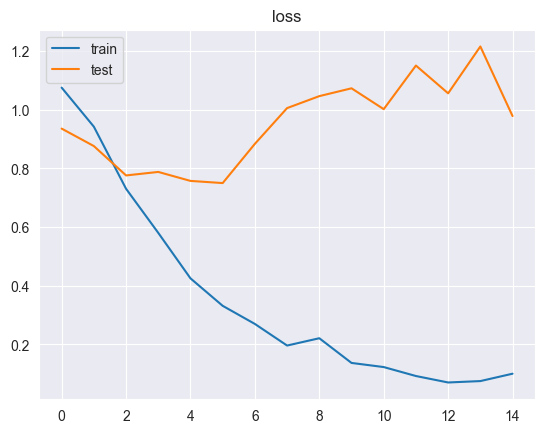

losssaved at manual_balanced_LSTM/0.3-15-32


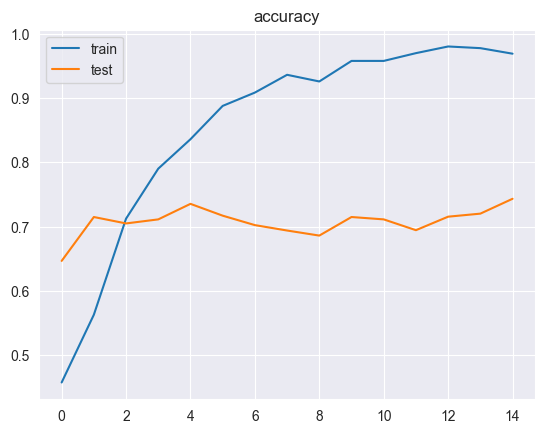

accuracysaved at manual_balanced_LSTM/0.3-15-32
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_30 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_15 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

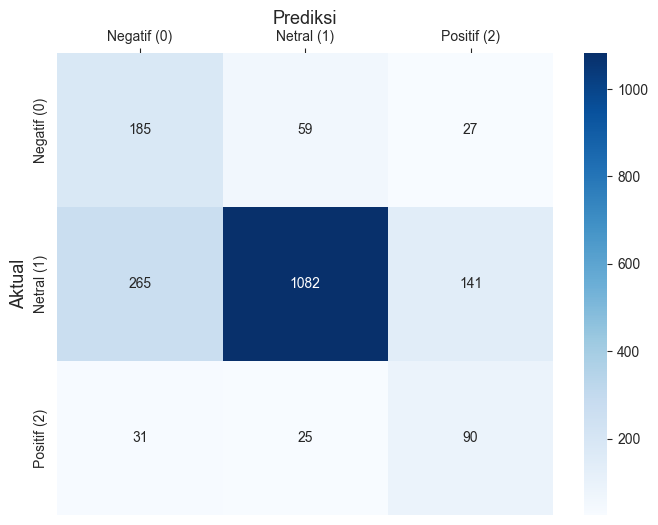

confusion matrix saved


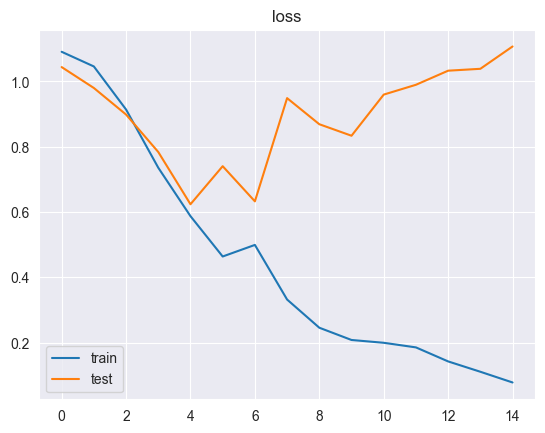

losssaved at manual_balanced_LSTM/0.3-15-64


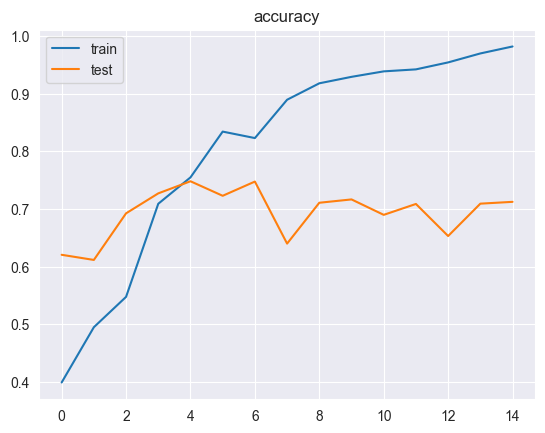

accuracysaved at manual_balanced_LSTM/0.3-15-64
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_32 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_16 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

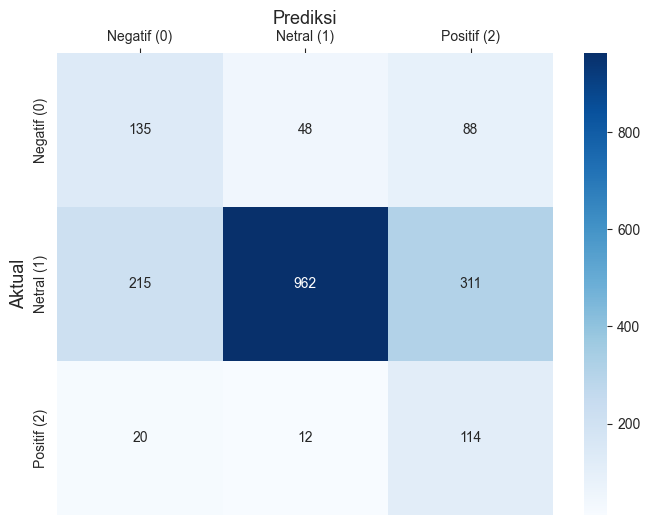

confusion matrix saved


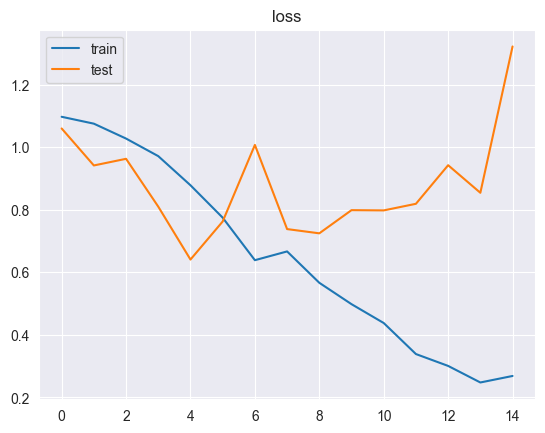

losssaved at manual_balanced_LSTM/0.3-15-128


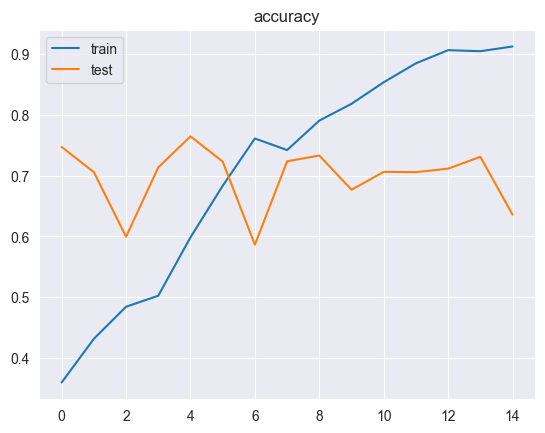

accuracysaved at manual_balanced_LSTM/0.3-15-128
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_34 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
________________________________________________________________

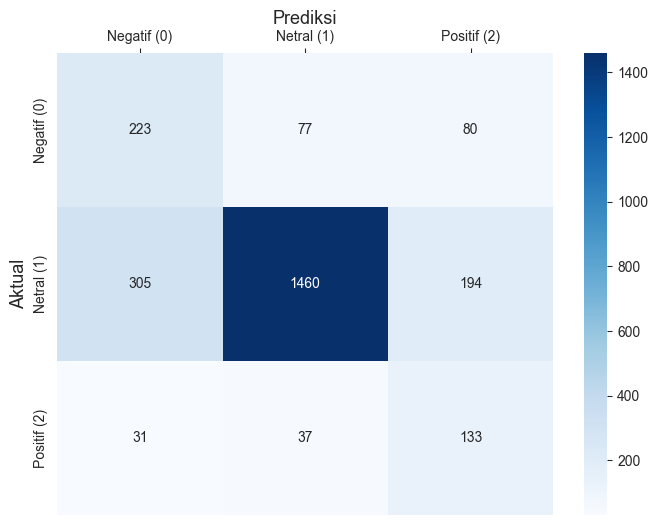

confusion matrix saved


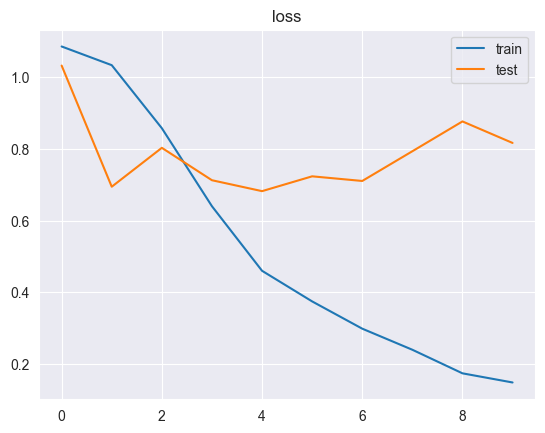

losssaved at manual_balanced_LSTM/0.4-10-32


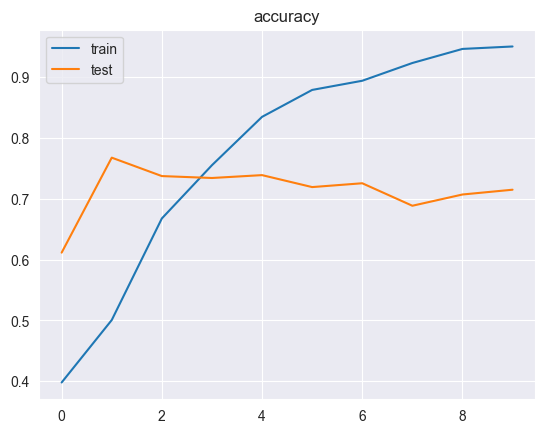

accuracysaved at manual_balanced_LSTM/0.4-10-32
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_36 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_18 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

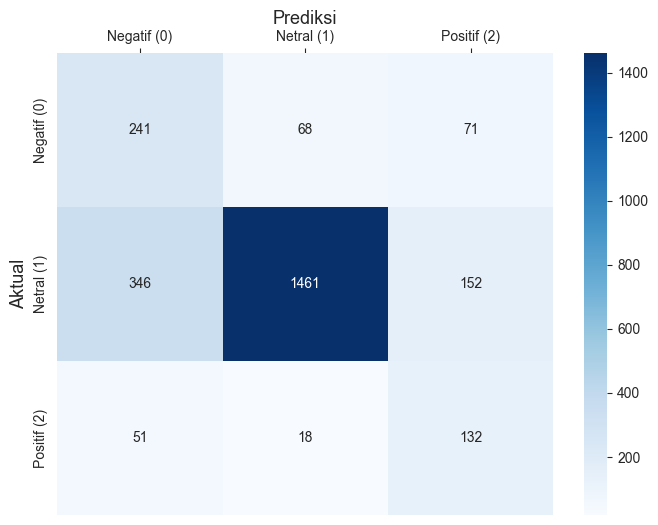

confusion matrix saved


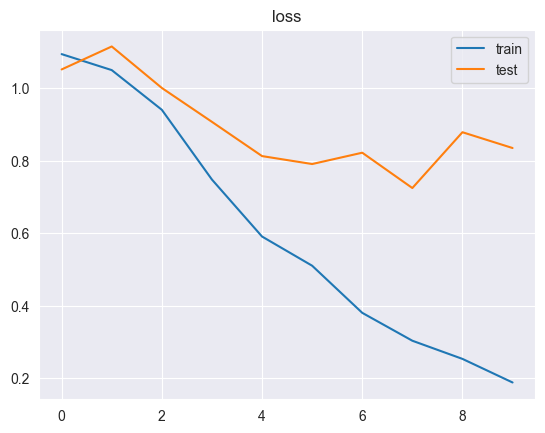

losssaved at manual_balanced_LSTM/0.4-10-64


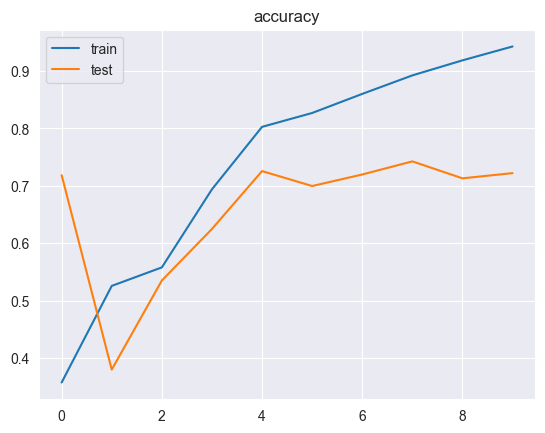

accuracysaved at manual_balanced_LSTM/0.4-10-64
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_38 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_19 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

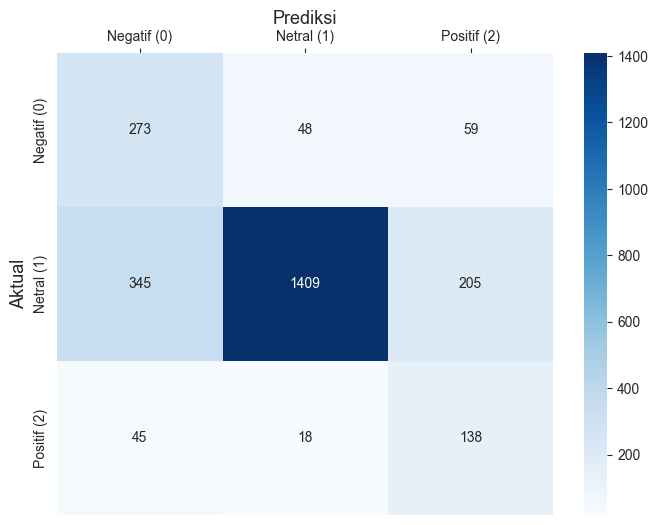

confusion matrix saved


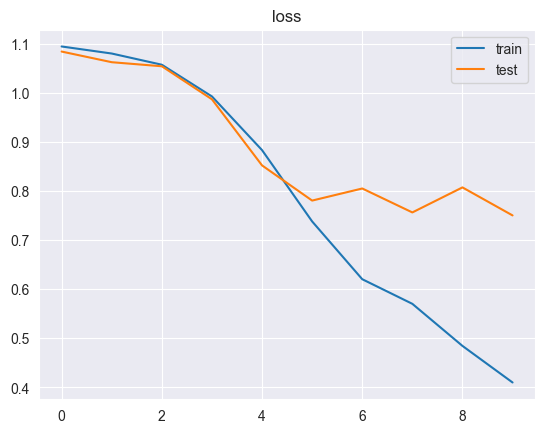

losssaved at manual_balanced_LSTM/0.4-10-128


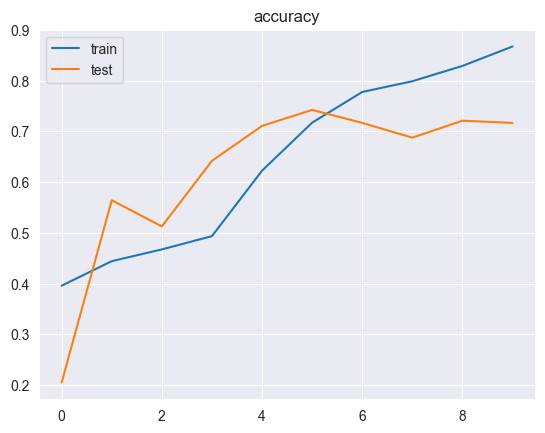

accuracysaved at manual_balanced_LSTM/0.4-10-128
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_40 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_20 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_41 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
________________________________________________________________

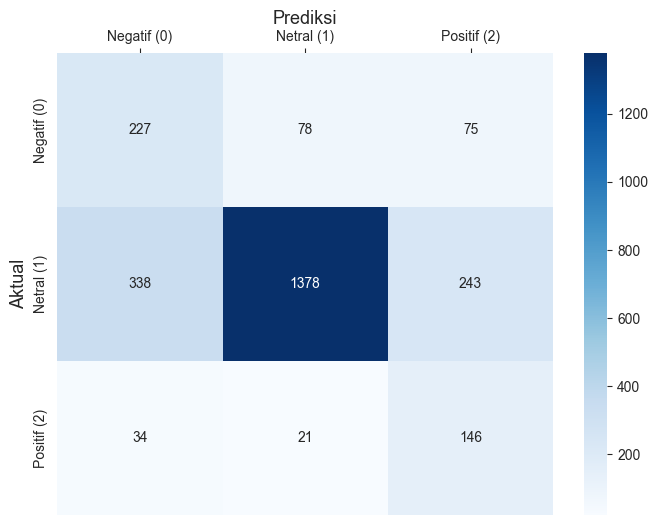

confusion matrix saved


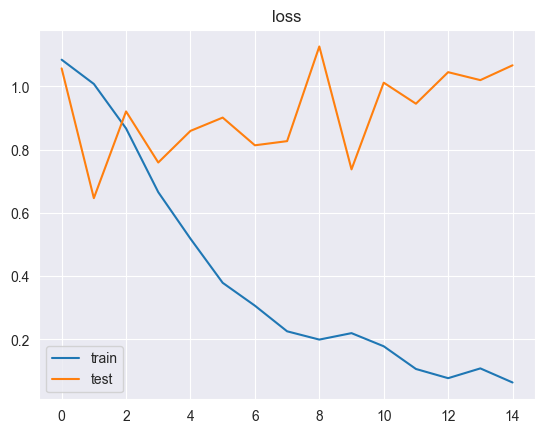

losssaved at manual_balanced_LSTM/0.4-15-32


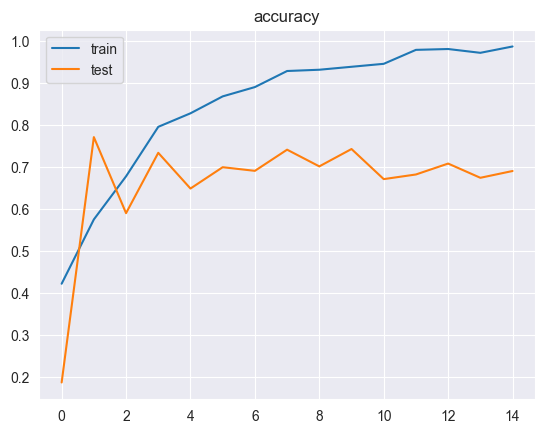

accuracysaved at manual_balanced_LSTM/0.4-15-32
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_42 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_21 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

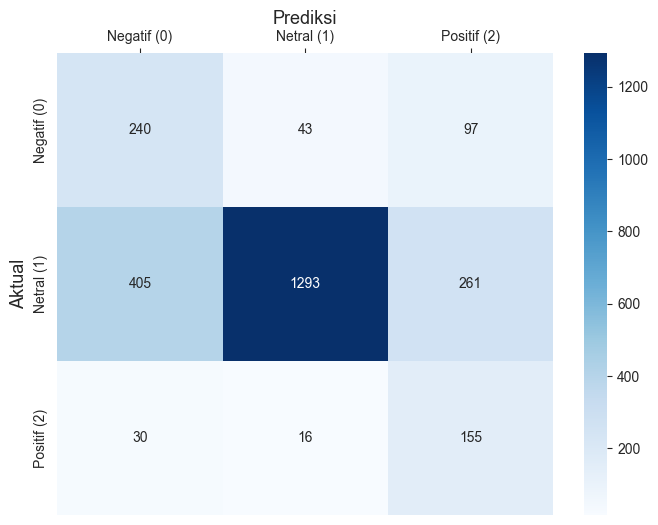

confusion matrix saved


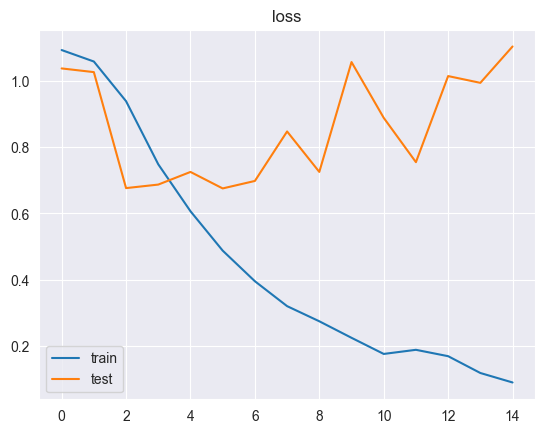

losssaved at manual_balanced_LSTM/0.4-15-64


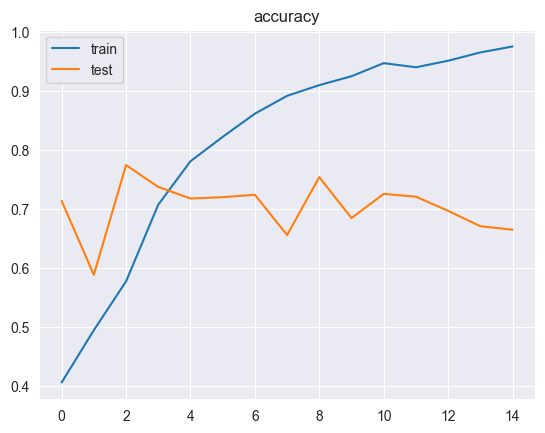

accuracysaved at manual_balanced_LSTM/0.4-15-64
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 57, 64)            320064    
                                                                 
 dropout_44 (Dropout)        (None, 57, 64)            0         
                                                                 
 lstm_22 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 3)                 387       
                                                                 
Total params: 419,267
Trainable params: 419,267
Non-trainable params: 0
_________________________________________________________________

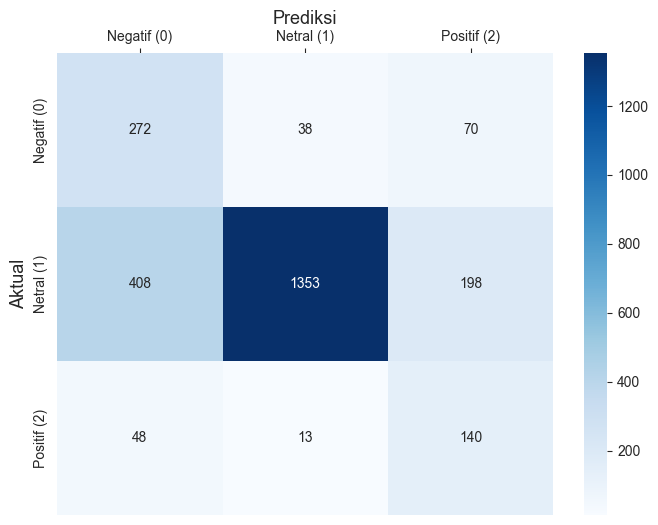

confusion matrix saved


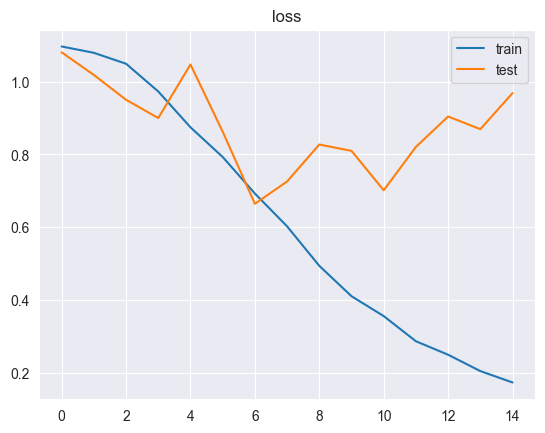

losssaved at manual_balanced_LSTM/0.4-15-128


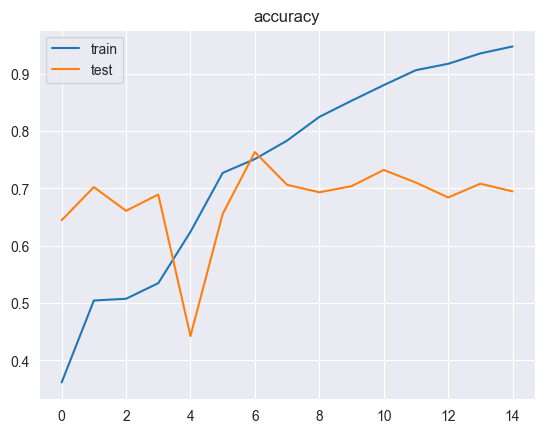

accuracysaved at manual_balanced_LSTM/0.4-15-128


In [20]:
train_ratio = [0.2,0.3,0.4]
batch_list = [32,64,128]
epochs_list = [10,15]
result_bucket = []
model_type = "LSTM"
for tl in train_ratio:
    for el in epochs_list:
        for bl in batch_list:
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=tl, random_state = 2)
            models = model_initiator(model_type)
            # new code
            under_sampling = RandomUnderSampler(random_state=0, replacement=True)
            X_train, y_train = under_sampling.fit_resample(X_train, y_train)
            #
            history = models.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=el, batch_size=bl, verbose=1)
            scores = models.evaluate(X_test, y_test, verbose=False)
            print(f"Accuracy: {scores[1]*100} %")
            y_pred = models.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)
            y_test = np.argmax(y_test, axis=1)
            acc = accuracy_score(y_test, y_pred)
            reports = classification_report(y_test,y_pred, target_names=['Negatif (0)', 'Netral (1)', 'Positif (2)'], output_dict=True)
            path_to_save = f"manual_balanced_{model_type}/{tl}-{el}-{bl}"
            os.makedirs(path_to_save, exist_ok=True)
            path_to_save_model = f"{path_to_save}/model.h5"
            models.save(path_to_save_model)
            print(conf_matrix(y_test,y_pred))
            print(plot(history, "loss"))
            print(plot(history, "accuracy"))
            to_save = f"{path_to_save}/classification_reports.csv"
            clsf_report = pd.DataFrame(reports).transpose()
            clsf_report.to_csv(to_save,sep=';')
            results = {
                'model': model_type,
                "batch_size": bl,
                "epoch": el,
                "train_ratio": tl,
                'accuracy_score': acc
            }
            result_bucket.append(results)
#
df_result = pd.DataFrame(result_bucket)
df_result.to_csv(path_or_buf=f'manual_balanced {model_type} reports.csv', sep=';')



In [44]:
train_ratio = [0.2,0.3,0.4]
batch_list = [32,64,128]
epochs_list = [10,15]
result_bucket = []
for tr in train_ratio:
    for el in epochs_list:
        for bl in batch_list:
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=tr, random_state = 0)
            model_lstm = Sequential()
            model_lstm.add(Embedding(input_dim=max_feature,output_dim=64, input_length=X.shape[1]))
            model_lstm.add(Dropout(0.5))
            model_lstm.add(GRU(units=64, dropout=0.2, recurrent_dropout=0.2))
            model_lstm.add(Dropout(0.5))
            model_lstm.add(Dense(units=3, activation="softmax"))
            model_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            model_lstm.summary()
            history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=el, batch_size=bl, verbose=1)
            scores = model_lstm.evaluate(X_test, y_test, verbose=False)
            print(f"Accuracy: {scores[1]*100} %")
            y_pred = model_lstm.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)
            y_test = np.argmax(y_test, axis=1)
            acc = accuracy_score(y_test, y_pred)
            reports = classification_report(y_test,y_pred, target_names=['Negatif (0)', 'Netral (1)', 'Positif (2)'], output_dict=True)
            # confusion_matrix(y_test, y_pred)
            fig, ax = plt.subplots(figsize = (8,6))
            sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True, cmap='Blues')
            ax.xaxis.set_label_position('top')
            ax.xaxis.set_ticks_position('top')
            ax.set_xlabel('Prediksi', fontsize=13)
            ax.set_xticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
            ax.set_ylabel('Aktual', fontsize=13)
            ax.set_yticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
            path_to_save = f"GRU-{tr}-{el}-{bl}"
            os.makedirs(path_to_save, exist_ok=True)
            to_save = f"{path_to_save}/CF.png"
            plt.savefig(fname=to_save, format='png')
            plt.show()
            plt.close()
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.plot(history.history['loss'], label = 'train')
            plt.plot(history.history['val_loss'], label = 'test')
            plt.legend()
            to_save = f"{path_to_save}/loss.png"
            plt.savefig(to_save)
            plt.show()
            plt.close()
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.plot(history.history['accuracy'], label='train')
            plt.plot(history.history['val_accuracy'], label='test')
            plt.legend()
            to_save = f"{path_to_save}/acc.png"
            plt.savefig(to_save)
            plt.show()
            plt.close()
            to_save = f"{path_to_save}/classification_reports.csv"
            clsf_report = pd.DataFrame(reports).transpose()
            clsf_report.to_csv(to_save,sep=';')
            results = {
                'model': "GRU",
                "batch_size": bl,
                "epoch": el,
                "train_ratio": tr,
                'accuracy_score': acc
            }
            result_bucket.append(results)
            break
        break
    break
df_result = pd.DataFrame(result_bucket)
df_result.to_csv('GRU reports.csv', sep=';')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 62, 64)            320000    
                                                                 
 dropout_6 (Dropout)         (None, 62, 64)            0         
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 345,155
Trainable params: 345,155
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
135/159 [========================>...

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_3/embedding_3/embedding_lookup' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\nest_asyncio.py", line 120, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\anand\AppData\Local\Temp\ipykernel_19192\3702483986.py", line 17, in <module>
      history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=el, batch_size=bl, verbose=1)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "E:\pythonProject\final\skripsi_bert_ngab\venv\lib\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_3/embedding_3/embedding_lookup'
indices[2,1] = 5000 is not in [0, 5000)
	 [[{{node sequential_3/embedding_3/embedding_lookup}}]] [Op:__inference_train_function_20142]

# Tuning Hyperparameter

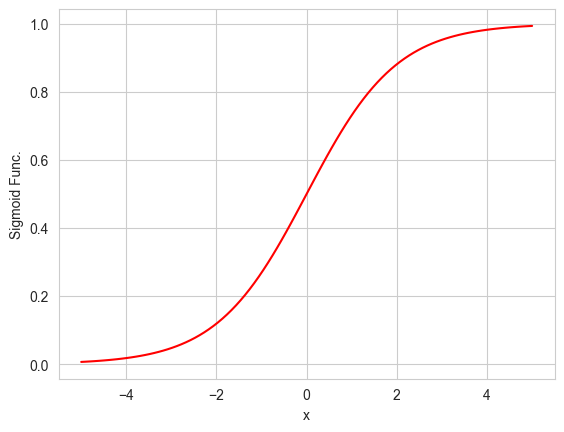

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import math

x = np.linspace(-5, 5, 100)
z = 1/(1 + np.exp(-x))
# z = np.tanh(x)

plt.plot(x, z, color='red')
plt.xlabel("x")
plt.ylabel("Sigmoid Func.")

# plt.show()
plt.savefig('sigmoid_graph.png')